## Семинар 3 "Определение ключевых точек лица"

ФИО: Ногина Дарья

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  22 марта 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [2]:
! pip install tensorboardX
! pip install pytorch-ignite

     |████████████████████████████████| 317kB 7.7MB/s 
     |████████████████████████████████| 194kB 7.5MB/s 


In [3]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
# Ignore warnings
import warnings
from tqdm import tqdm

try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss




In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
d_folder = "/content/gdrive/MyDrive/Colab Notebooks/tf_task3/Seminar 3/"

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, device='cpu'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        filenames = self.landmarks_frame.iloc[:, 0]
        for filename in tqdm(filenames):
          self.images.append(io.imread(os.path.join(self.root_dir, filename)))

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        image = self.images[idx]
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return torch.from_numpy(np.array([image])).type(torch.float).to(device), torch.from_numpy(landmarks).type(torch.float).to(device)

In [37]:
import pickle

with open(d_folder + 'train_dataset.pkl', 'rb') as handle:
    train_dataset = pickle.load(handle)

with open(d_folder + 'test_dataset.pkl', 'rb') as handle:
    test_dataset = pickle.load(handle)

In [17]:
"""
train_dataset = FaceLandmarksDataset(csv_file=d_folder + 'dataset/train/face_landmarks.csv',
                                     root_dir=d_folder +'dataset/train',
                                     device='cuda')

test_dataset = FaceLandmarksDataset(csv_file=d_folder + 'dataset/test/face_landmarks.csv',
                                     root_dir=d_folder +'dataset/test',
                                     device='cuda')"""


100%|██████████| 1589/1589 [00:02<00:00, 596.13it/s]


In [156]:
"""import pickle
with open(d_folder + 'train_dataset.pkl', 'wb') as handle:
    pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(d_folder + 'test_dataset.pkl', 'wb') as handle:
    pickle.dump(test_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

In [8]:
def get_data_loaders(train_batch_size=64, val_batch_size=64, train_dataset_=train_dataset, test_dataset_=test_dataset):
 
    train_loader = DataLoader(
        train_dataset_, batch_size=train_batch_size, shuffle=True
    )
 
    test_loader = DataLoader(
        test_dataset_, batch_size=val_batch_size, shuffle=False
    )
 
    return train_loader, test_loader

__Baseline__

In [31]:
from torch import nn

# idea for the main structure is taken from here:
# https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict
 
class Net(Module):
 
    def __init__(self, activation=Tanh(), latent_size=200):
        super().__init__()
 
        self.encoder = Sequential(
                    nn.Conv2d(1, 16, kernel_size=3, padding=1),  
                    nn.BatchNorm2d(16),                   
                    nn.LeakyReLU(),                    
                    nn.AvgPool2d(2),
                                         
                    nn.Conv2d(16, 32, kernel_size=3, padding=1), 
                    nn.BatchNorm2d(32),                   
                    nn.LeakyReLU(),                    
                    nn.AvgPool2d(2),
 
                    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                    nn.BatchNorm2d(64),                   
                    nn.LeakyReLU(),
                    nn.AvgPool2d(2),
                    nn.Dropout(p=0.001)
                    )
        self.decoder = nn.Sequential(
                    nn.Linear(64 * 12 * 12, 68*2*2), 
                    nn.BatchNorm1d(68*2*2),
                    nn.LeakyReLU(),
                    #nn.Dropout(p=0.01), 
                    #авторы оригинальной статьи говорят, что лучше dropout делать здесь, 
                    # а не после конволюций, но у меня оно работает именно так, и было показано, что маленький дропаут после конволюции полезен
 
                    nn.Linear(68*2*2,68*2),
                    )
    def forward(self, x):
        
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x.view(x.size(0), 68, 2)

In [32]:
network = Net()
#network = UNet()
if torch.cuda.is_available():
    network.cuda()
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="logs")
 
device = "cpu"
 
if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 30
 
optimizer = optim(network.parameters(), lr=learning_rate)
 
trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)
 
training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [33]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()
 
 
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))

Avg MSE: 3.17 / 5.28

In [34]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 30  Avg MSE: 3.17 / 5.28 Avg MAE: 1.32 / 1.58

State:
	iteration: 2940
	epoch: 30
	epoch_length: 98
	max_epochs: 30
	output: 3.2047793865203857
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Сошлось, но довольно неуверенно, поэтому и baseline

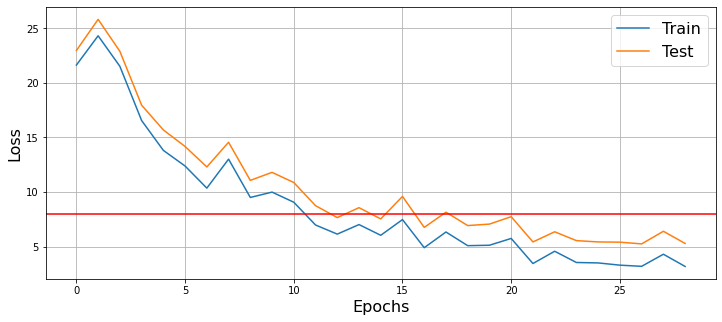

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.axhline(y=8, color='r', linestyle='-')
plt.grid('on')
plt.show()

__Косметические изменения baseline__


In [103]:
class Net_2(Module):
 
    def __init__(self, activation=Tanh(), latent_size=200):
        super().__init__()

        self.encoder = Sequential(
                    
                    nn.Conv2d(1, 16, kernel_size=3, padding=1, padding_mode='replicate'),  
                    nn.BatchNorm2d(16),                   
                    nn.LeakyReLU(),                    
                    nn.MaxPool2d(2),
                                         
                    nn.Conv2d(16, 32, kernel_size=3, padding=1, padding_mode='replicate'), 
                    nn.BatchNorm2d(32),                   
                    nn.LeakyReLU(),                    
                    nn.MaxPool2d(2),
 
                    nn.Conv2d(32, 64, kernel_size=3, padding=1, padding_mode='replicate'), 
                    nn.BatchNorm2d(64),                   
                    nn.LeakyReLU(),
                    nn.MaxPool2d(2),
                    nn.Dropout(p=0.001)

                    )
        self.decoder = nn.Sequential(
                    nn.Linear(64 * 12 * 12, 68*2*2), 
                    nn.BatchNorm1d(68*2*2),
                    nn.LeakyReLU(),
                    #nn.Dropout(p=0.01), 
                    #авторы оригинальной статьи говорят, что лучше dropout делать здесь, 
                    # а не после конволюций, но у меня оно работает именно так, и было показано, что маленький дропаут после конволюции полезен
                    nn.Linear(68*2*2,68*2),
                    )
        # He, т.к. Xavier работает только для Softmax
        [torch.nn.init.kaiming_normal_(self.encoder[i].weight, nonlinearity='leaky_relu') for i in [0, 4, 8]]
        [torch.nn.init.kaiming_normal_(self.decoder[i].weight, nonlinearity='leaky_relu') for i in [0, 3]]
    def forward(self, x):
        
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x.view(x.size(0), 68, 2)

In [104]:
network = Net_2()
if torch.cuda.is_available():
    network.cuda()
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="logs")
 
device = "cpu"
 
if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 30
 
optimizer = optim(network.parameters(), lr=learning_rate)
 
trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)
 
training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()
 
 
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
    
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 30  Avg MSE: 2.81 / 5.36 Avg MAE: 1.26 / 1.59

State:
	iteration: 2940
	epoch: 30
	epoch_length: 98
	max_epochs: 30
	output: 4.743905067443848
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Avg MSE: 2.81 / 5.36

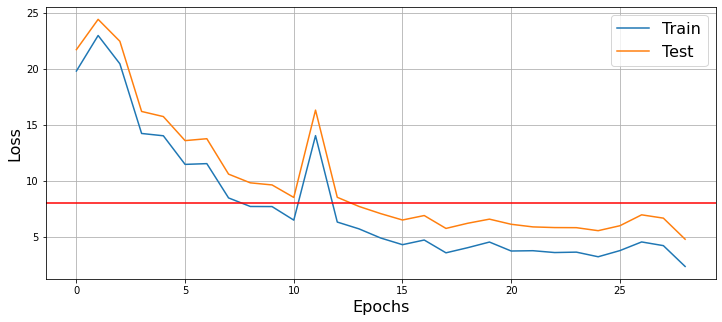

In [101]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.axhline(y=8, color='r', linestyle='-')
plt.grid('on')
plt.show()

__Not pretrained ResNet__

In [136]:
class FaceLandmarksDataset_ResNet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, device='cpu'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        filenames = self.landmarks_frame.iloc[:, 0]
        for filename in tqdm(filenames):
          self.images.append(io.imread(os.path.join(self.root_dir, filename)))

        self.landmarks = self.landmarks_frame.iloc[:, 1:].values.astype('float')

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        image = self.images[idx]
        landmarks = self.landmarks[idx]
        #landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return torch.from_numpy(np.array([image])).type(torch.float).to(device), torch.from_numpy(landmarks).type(torch.float).to(device)

In [137]:
train_dataset_resnet = FaceLandmarksDataset_ResNet(csv_file=d_folder + 'dataset/train/face_landmarks.csv',
                                     root_dir=d_folder +'dataset/train',
                                     device='cuda')

test_dataset_resnet = FaceLandmarksDataset_ResNet(csv_file=d_folder + 'dataset/test/face_landmarks.csv',
                                     root_dir=d_folder +'dataset/test',
                                     device='cuda')

100%|██████████| 1589/1589 [00:02<00:00, 571.15it/s]


In [138]:
class Net_ResNet(Module):
  def __init__(self, classes_n = 68 * 2):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, classes_n) # * 1 because of use of the Basic block
        #self.avgpool = nn.Identity()
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

  def forward(self, x):
        x = self.model(x)
        return x

In [139]:
network = Net_ResNet()
if torch.cuda.is_available():
    network.cuda()
train_dataloader, test_dataloader = get_data_loaders(train_dataset_=train_dataset_resnet, test_dataset_=test_dataset_resnet)
writer = SummaryWriter(filename_suffix='first', logdir="logs")
 
device = "cpu"
 
if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 30
 
optimizer = optim(network.parameters(), lr=learning_rate)
 
trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)
 
training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()
 
 
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
    
trainer.run(train_dataloader, max_epochs=max_epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Training/Validation Results - Epoch: 30  Avg MSE: 1.25 / 3.14 Avg MAE: 0.85 / 1.12

State:
	iteration: 2940
	epoch: 30
	epoch_length: 98
	max_epochs: 30
	output: 2.4744040966033936
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Avg MSE: 1.25 / 3.14

Вот так намного лучше!

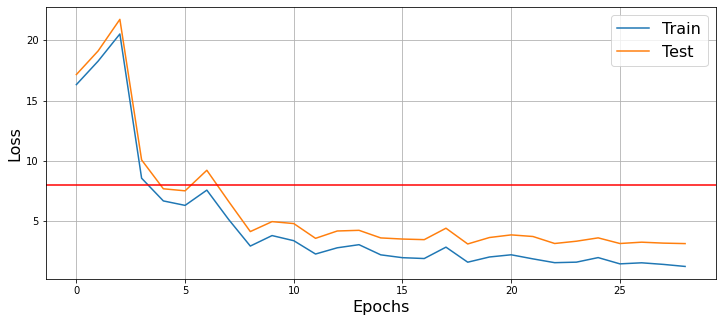

In [140]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.axhline(y=8, color='r', linestyle='-')
plt.grid('on')
plt.show()

In [161]:
_, test_dataloader = get_data_loaders(val_batch_size=2)

images_batch = next(iter(test_dataloader))
x, y = images_batch

y_pred = network(x)
y_pred = y_pred.cpu().data.numpy()
#show_landmarks_batch(images_batch, y_pred)

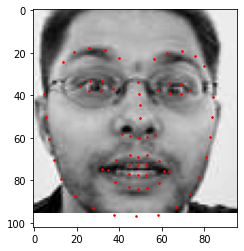

In [205]:
plt.imshow(x[0].cpu().numpy().transpose(1,0,2).reshape(96, -1), cmap="gray")
plt.scatter(x=y_pred[0].reshape(-1,2)[:,0], y=y_pred[0].reshape(-1,2)[:, 1], s=10, marker='.', c='r',)

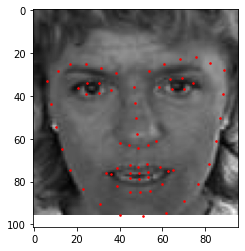

In [206]:
plt.imshow(x[1].cpu().numpy().transpose(1,0,2).reshape(96, -1), cmap="gray")
plt.scatter(x=y_pred[1].reshape(-1,2)[:,0], y=y_pred[1].reshape(-1,2)[:, 1], s=10, marker='.', c='r',)

Посмотрим, что получится, если использовать предобученнную модель

In [9]:
class Net_ResNet_pretr(Module):
  def __init__(self, classes_n = 68 * 2):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        # self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) вот это уже переопределять не надо, поэтому resize-нем картинку
        # переопределим последний линейный слой
        self.model.fc = nn.Linear(self.model.fc.in_features, classes_n) # * 1 because of use of the Basic block

  def forward(self, x):
        x = self.model(x)
        return x

In [24]:
! pip install pillow
from PIL import Image

In [128]:
class FaceLandmarksDataset_preResNet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, device='cpu'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        filenames = self.landmarks_frame.iloc[:, 0]
        for filename in tqdm(filenames):
          img = np.asarray(Image.open(os.path.join(self.root_dir, filename)).convert("RGB"))
          self.images.append(img)

        self.landmarks = self.landmarks_frame.iloc[:, 1:].values.astype('float')

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(3, 96, 96)
        landmarks = self.landmarks[idx]
        sample = image, landmarks


        if self.transform:
            sample = self.transform(sample)

        return torch.from_numpy(np.squeeze(image)).type(torch.float).to(device), torch.from_numpy(landmarks).type(torch.float).to(device)

In [129]:
train_dataset_preresnet = FaceLandmarksDataset_preResNet(csv_file=d_folder + 'dataset/train/face_landmarks.csv',
                                     root_dir=d_folder +'dataset/train',
                                     device='cuda')

test_dataset_preresnet = FaceLandmarksDataset_preResNet(csv_file=d_folder + 'dataset/test/face_landmarks.csv',
                                     root_dir=d_folder +'dataset/test',
                                     device='cuda')

100%|██████████| 1589/1589 [00:01<00:00, 888.80it/s]


In [130]:
network = Net_ResNet_pretr()
if torch.cuda.is_available():
    network.cuda()
train_dataloader, test_dataloader = get_data_loaders(train_dataset_=train_dataset_preresnet, test_dataset_=test_dataset_preresnet)
writer = SummaryWriter(filename_suffix='first', logdir="logs")
 
device = "cpu"
 
if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 30
 
optimizer = optim(network.parameters(), lr=learning_rate)
 
trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)
 
training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()
 
 
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
    
trainer.run(train_dataloader, max_epochs=max_epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Training/Validation Results - Epoch: 30  Avg MSE: 2.21 / 7.08 Avg MAE: 1.12 / 1.71

State:
	iteration: 2940
	epoch: 30
	epoch_length: 98
	max_epochs: 30
	output: 4.309808731079102
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Avg MSE: 2.21 / 7.08

Очень нехорошо дообучилась. Возможно, стоит попробовать обновить несколько предыдущих слоев (?).

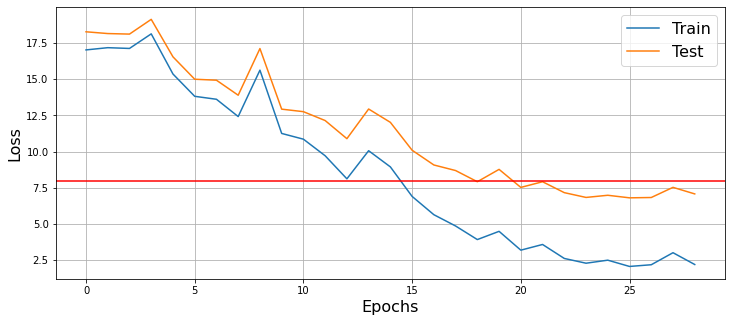

In [131]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.axhline(y=8, color='r', linestyle='-')
plt.grid('on')
plt.show()

In [132]:
class Net_ResNet_pretr(Module):
  def __init__(self, classes_n = 68 * 2):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        # заморозим всю сеть до последнего слоя
        for param in self.model.parameters():
          param.requires_grad = False
        # self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) вот это уже переопределять не надо, поэтому resize-нем картинку
        # переопределим последний линейный слой
        self.model.fc = nn.Linear(self.model.fc.in_features, classes_n) # * 1 because of use of the Basic block

  def forward(self, x):
        x = self.model(x)
        return x

In [134]:
network = Net_ResNet_pretr()
if torch.cuda.is_available():
    network.cuda()
train_dataloader, test_dataloader = get_data_loaders(train_dataset_=train_dataset_preresnet, test_dataset_=test_dataset_preresnet)
writer = SummaryWriter(filename_suffix='first', logdir="logs")
 
device = "cpu"
 
if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 200
 
optimizer = optim(network.parameters(), lr=learning_rate)
 
trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)
 
training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()
 
 
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
    
trainer.run(train_dataloader, max_epochs=max_epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Training/Validation Results - Epoch: 200  Avg MSE: 15.63 / 19.08 Avg MAE: 2.85 / 3.14

State:
	iteration: 19600
	epoch: 200
	epoch_length: 98
	max_epochs: 200
	output: 10.777081489562988
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Avg MSE: 15.63 / 19.08

Видимо, искуственное превращение чб картинки в цветную влияет на начальные слои, отвечающие за распознавание простых паттернов. Поэтому даже если дать предобученному ResNet 200 эпох, он не справится с замороженными градиентами

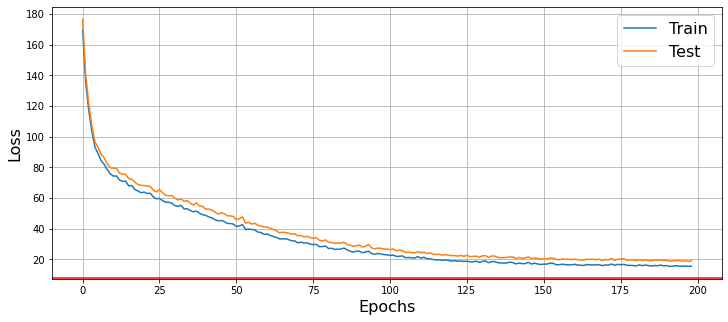

In [135]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.axhline(y=8, color='r', linestyle='-')
plt.grid('on')
plt.show()